### Let's start with downloading the raw data

In [19]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [ ]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'kickstarter',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'yashkantharia/kickstarter-campaigns',
    'files': ['Kickstarter_projects_Feb19.csv'],
    'rename_files': ['kickstarter_data.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'status',
}

In [21]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/kockstarter.
Downloaded kockstarter dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/kockstarter


### Now we need to preprocess the data

In [22]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [23]:
# TODO: we will downsample the dataset to ~24k samples

import os
import pandas as pd

# Define the path
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

# File paths
train_path = os.path.join(download_path, dataset_config['rename_files'][0])

# Load safely, skipping bad lines
train_df = pd.read_csv(train_path, on_bad_lines='skip', engine='python')

# Downsample with fallback if not enough rows
train_sample_size = min(len(train_df), 24000)

train_df = train_df.sample(n=train_sample_size, random_state=42).reset_index(drop=True)

# Save back (overwrite the originals)
train_df.to_csv(train_path, index=False)


In [24]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/kockstarter/kickstarter_data.csv


,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1259776051,Kubrick By Candlelight,GBP,film & video,Comedy,2016-11-17 00:38:54,2016-12-17 00:38:54,30.0,6451.66285,Tullamore,Offaly,GB,21,3,successful,11,12,Q4,Q4,6604.656993
1,821456437,The Othermill: Custom Circuits at Your Fingertips,USD,technology,Hardware,2013-05-05 19:45:11,2013-06-04 19:45:11,30.0,50000.00000,San Francisco,CA,US,20,7,successful,5,6,Q2,Q2,311657.100000
2,314772357,Audeara: headphones that deliver perfect sound...,AUD,technology,Sound,2017-02-28 18:52:47,2017-04-14 17:52:47,45.0,71325.60800,Brisbane,QLD,AU,19,7,successful,2,4,Q1,Q2,358751.730739


In [25]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (24000, 20) / (23660, 20)


In [34]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['usd_pledged', 'id'] # to remove target leakage

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Column usd_pledged not found in dataframe
Dataframe shape before/afrer by-hand cleaning: (23660, 19) / (23660, 18)


,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q
0,Kubrick By Candlelight,GBP,film & video,Comedy,2016-11-17 00:38:54,2016-12-17 00:38:54,30.0,6451.66285,Tullamore,Offaly,GB,21,3,successful,11,12,Q4,Q4
1,The Othermill: Custom Circuits at Your Fingertips,USD,technology,Hardware,2013-05-05 19:45:11,2013-06-04 19:45:11,30.0,50000.00000,San Francisco,CA,US,20,7,successful,5,6,Q2,Q2
2,Audeara: headphones that deliver perfect sound...,AUD,technology,Sound,2017-02-28 18:52:47,2017-04-14 17:52:47,45.0,71325.60800,Brisbane,QLD,AU,19,7,successful,2,4,Q1,Q2


In [41]:
# TODO: some custom data cleaning

import copy 
import pandas as pd

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    # 1. Convert to datetime safely
    df_file['launched_at'] = pd.to_datetime(df_file['launched_at'], errors='coerce')
    df_file['deadline'] = pd.to_datetime(df_file['deadline'], errors='coerce')
    
    # 2. Convert datetime to Unix timestamp as float (seconds since epoch)
    df_file['launched_at'] = df_file['launched_at'].astype('int64') / 1e9  # nanoseconds to seconds
    df_file['deadline'] = df_file['deadline'].astype('int64') / 1e9

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# Reset the dataframe list to pre-cleaning version
dataset_files_cleaned = tmp_df


Dataframe shape before custom cleaning: (23660, 18)
Dataframe shape after custom cleaning: (23660, 18)


### Now it is time to visualize our changes

In [42]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q
0,Kubrick By Candlelight,GBP,film & video,Comedy,1.479343e+09,1.481935e+09,30.0,6451.66285,Tullamore,Offaly,GB,21,3,successful,11,12,Q4,Q4
1,The Othermill: Custom Circuits at Your Fingertips,USD,technology,Hardware,1.367783e+09,1.370375e+09,30.0,50000.00000,San Francisco,CA,US,20,7,successful,5,6,Q2,Q2
2,Audeara: headphones that deliver perfect sound...,AUD,technology,Sound,1.488308e+09,1.492192e+09,45.0,71325.60800,Brisbane,QLD,AU,19,7,successful,2,4,Q1,Q2


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [43]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (4): ['launched_at', 'deadline', 'duration', 'goal_usd']
Categorical columns (10): ['currency', 'main_category', 'country', 'blurb_length', 'name_length', 'status', 'start_month', 'end_month', 'start_Q', 'end_Q']
Textual columns (4): ['name', 'sub_category', 'city', 'state']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [44]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,name,Kubrick By Candlelight,textual,23614
1,currency,GBP,categorical,14
2,main_category,film & video,categorical,15
3,sub_category,Comedy,textual,159
4,launched_at,1479343134.0,numerical,~ 23623 ~
5,deadline,1481935134.0,numerical,~ 23248 ~
6,duration,30.0,numerical,~ 82 ~
7,goal_usd,6451.66285,numerical,~ 2713 ~
8,city,Tullamore,textual,4058
9,state,Offaly,textual,555


### Saving the processed data and loading it back up

In [ ]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/kockstarter/kickstarter_data_processed.pkl


In [ ]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))



=== KICKSTARTER_DATA ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,name,textual,23614
1,currency,categorical,14
2,main_category,categorical,15
3,sub_category,textual,159
4,launched_at,numerical,~ 23623 ~
5,deadline,numerical,~ 23248 ~
6,duration,numerical,~ 82 ~
7,goal_usd,numerical,~ 2713 ~
8,city,textual,4058
9,state,textual,555


Column Name,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q
0,Kubrick By Candlelight,GBP,film & video,Comedy,1.479343e+09,1.481935e+09,30.0,6451.66285,Tullamore,Offaly,GB,21,3,successful,11,12,Q4,Q4
1,The Othermill: Custom Circuits at Your Fingertips,USD,technology,Hardware,1.367783e+09,1.370375e+09,30.0,50000.00000,San Francisco,CA,US,20,7,successful,5,6,Q2,Q2
2,Audeara: headphones that deliver perfect sound...,AUD,technology,Sound,1.488308e+09,1.492192e+09,45.0,71325.60800,Brisbane,QLD,AU,19,7,successful,2,4,Q1,Q2


### Bonus insights

Text(0.5, 1.0, "Distribution of 'status' target")

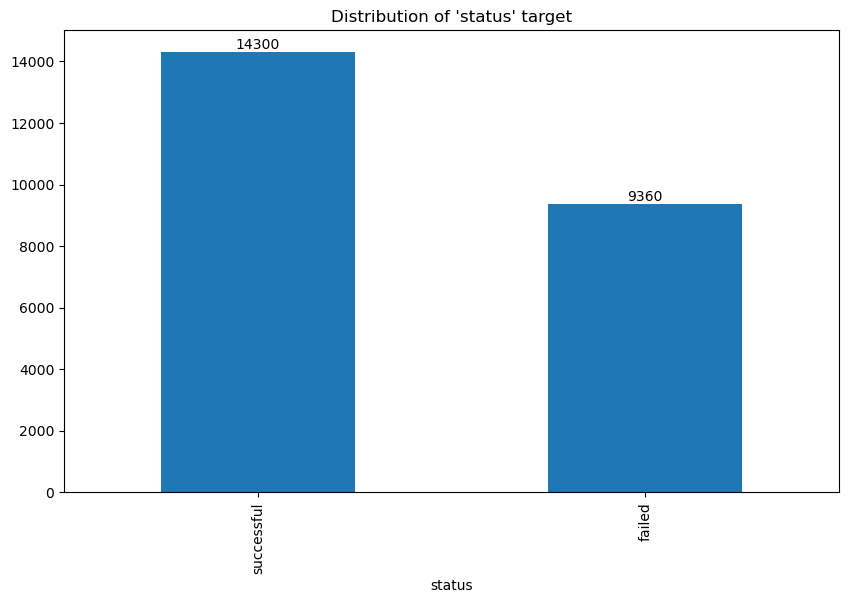

In [47]:
# show data imbalance:
import matplotlib.pyplot as plt

# Plot the distribution of player_class with counts
value_counts = loaded_df[dataset_config['target']].value_counts()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title(f"Distribution of '{dataset_config['target']}' target")

